## Gradient Boosting Notebook

*currently in-progress* 

In [169]:
# Data Manipulation
# ======================================================
import pandas as pd 
import numpy as np
from os import path
import configparser
from itertools import *
import math
from epiweeks import Week
from datetime import date, datetime
from calendar import month_name, month_abbr
from sklearn import preprocessing
from helper_functions import *

# Warnings Config
# ======================================================
import warnings
warnings.filterwarnings('ignore')

# Modeling & Forecasting
# ======================================================
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.regression.linear_model import OLS
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer, PolynomialFeatures
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector

from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect

from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Plotting
# ======================================================
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
df = pd.read_csv('data.csv', index_col='weekstart')
df.index = pd.to_datetime(df.index)
# Resampling data so pandas understands that it's weekly
df = df.reset_index().set_index('weekstart').resample('W').first().fillna(method='bfill')

In [180]:
end_train = date(2015,12,31)
end_validation = date(2017,12,31)

df_train = df.loc[:end_train,:]
df_val = df.loc[end_train:end_validation,:]
df_test = df.loc[end_validation:,:]

print(f"Dates train      : {df_train.index.min()} --- {df_train.index.max()}  (n={len(df_train)})")
print(f"Dates validacion : {df_val.index.min()} --- {df_val.index.max()}  (n={len(df_val)})")
print(f"Dates test       : {df_test.index.min()} --- {df_test.index.max()}  (n={len(df_test)})")

Dates train      : 2004-12-26 00:00:00 --- 2015-12-27 00:00:00  (n=575)
Dates validacion : 2016-01-03 00:00:00 --- 2017-12-31 00:00:00  (n=105)
Dates test       : 2017-12-31 00:00:00 --- 2019-12-29 00:00:00  (n=105)


In [184]:
data = df.copy()
data['set'] = 0

In [185]:
data['set'].loc[:end_train] = 'train'
data['set'].loc[end_train:end_validation] = 'val'
data['set'].loc[end_validation:] = 'test'

In [186]:
data['month'] = data.index.month
data['month'] = data['month'].map(lambda x: month_abbr[x])

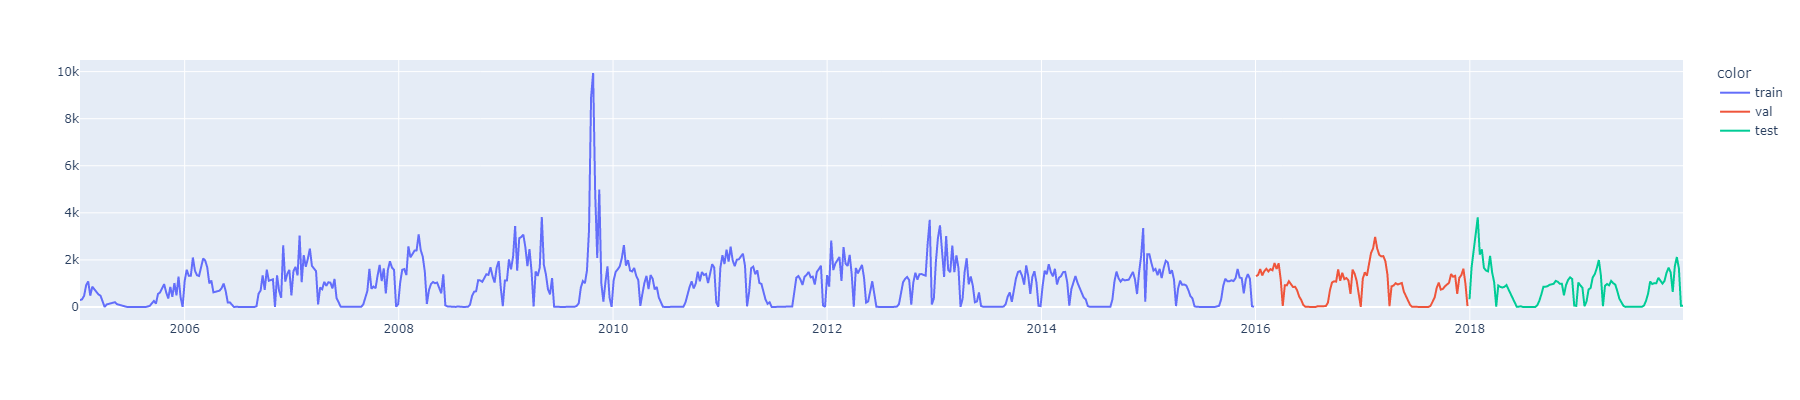

In [187]:
fig = px.line(x= data.index, y= data['cases'], color= data['set'])
fig.update_layout(autosize=False, width=1800, height=400)
fig.update_xaxes(title='')
fig.update_yaxes(title='')
fig.show('png')

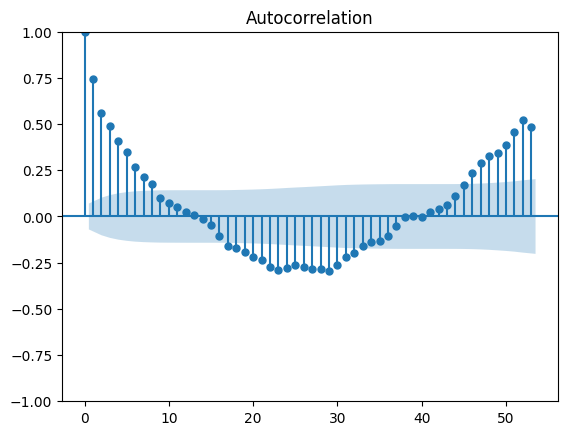

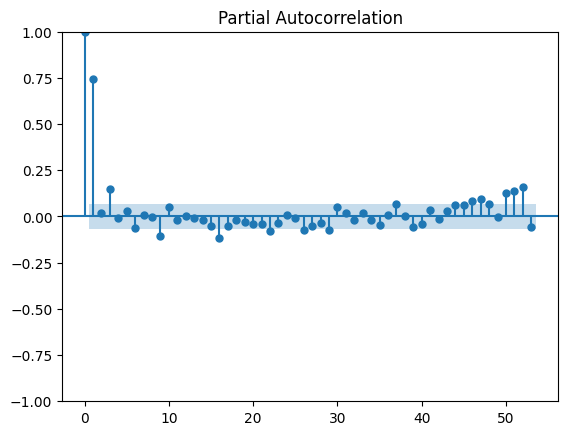

In [188]:
# Autocorrelation plots
plot_acf(data['cases'], lags=53).show()
plot_pacf(data['cases'], lags=53).show()

The autocorrelation plots demonstrate significant correlations between cases in previous weeks and cases in the future. This means we may be able to use lagged cases to predict future cases.

In [189]:
# Create baseline: cases of the same week of the previous year
# ==============================================================================

forecaster_eq_dt = ForecasterEquivalentDate(
                offset    = pd.DateOffset(weeks=52),
                n_offsets = 2,
                agg_func  = np.mean
            )

# Train forecaster
# ==============================================================================
forecaster_eq_dt.fit(y=df.loc[:end_train, 'cases'])
forecaster_eq_dt

ForecasterEquivalentDate 
Offset: <DateOffset: weeks=52> 
Number of offsets: 2 
Aggregation function: mean 
Window size: 104 
Training range: [Timestamp('2005-01-09 00:00:00'), Timestamp('2015-12-27 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-SUN 
Creation date: 2024-01-23 12:37:17 
Last fit date: 2024-01-23 12:37:17 
Skforecast version: 0.11.0 
Python version: 3.11.5 
Forecaster id: None 

In [190]:
# Backtesting
# ==============================================================================
metric_eq_dt, predictions_eq_dt = backtesting_forecaster(
                                forecaster         = forecaster_eq_dt,
                                y                  = df.loc[:end_validation]['cases'],
                                steps              = 6,
                                metric             = 'mean_absolute_error',
                                initial_train_size = len(df.loc[:end_train]),
                                refit              = False,
                                n_jobs             = 'auto',
                                verbose            = False,
                                show_progress      = True
                            )

print(f"Backtest error (MAE): {metric_eq_dt}")

100%|██████████| 18/18 [00:00<00:00, 188.69it/s]

Backtest error (MAE): 216.3428497314453


In [191]:
# Create forecaster
# ==============================================================================
forecaster_ar1 = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 52
            )

# Train forecaster
# ==============================================================================
forecaster_ar1.fit(y=df.loc[:end_train, 'cases'])
forecaster_ar1

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52] 
Transformer for y: None 
Transformer for exog: None 
Window size: 52 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2005-01-09 00:00:00'), Timestamp('2015-12-27 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-SUN 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsamp

In [192]:
# Backtest model on test data
# ==============================================================================
metric_ar1, predictions_ar1 = backtesting_forecaster(
                        forecaster         = forecaster_ar1,
                        y                  = df.loc[:end_validation]['cases'],
                        steps              = 6,
                        metric             = 'mean_absolute_error',
                        initial_train_size = len(df[:end_train]),
                        refit              = False,
                        n_jobs             = 'auto',
                        verbose            = False,
                        show_progress      = True
                    )

print(f'Backtest error (MAE): {metric_ar1}')

100%|██████████| 18/18 [00:00<00:00, 122.25it/s]

Backtest error (MAE): 257.1923846903494


In [193]:
# Hyperparameters search
# ==============================================================================
# Lags grid
lags_grid = [[1],[1,52],[1,2],[1,2,52],[1,2,3],[1,2,3,52]]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'     : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5),
        'reg_alpha'     : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'    : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
    } 
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
                                forecaster         = forecaster_ar1,
                                y                  = df.loc[:end_validation, 'cases'], # Test data not used
                                search_space       = search_space,
                                lags_grid          = lags_grid,
                                steps              = 6,
                                refit              = False,
                                metric             = 'mean_absolute_error',
                                initial_train_size = len(df_train),
                                fixed_train_size   = False,
                                n_trials           = 20, # Increase this value for a more exhaustive search
                                random_state       = 123,
                                return_best        = True,
                                n_jobs             = 'auto',
                                verbose            = False,
                                show_progress      = True
                            )

Number of models compared: 120,
         20 bayesian search in each lag configuration.


lags grid: 100%|██████████| 6/6 [00:33<00:00,  5.63s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 52] 
  Parameters: {'n_estimators': 1200, 'max_depth': 8, 'learning_rate': 0.018066668056670537, 'reg_alpha': 0.8, 'reg_lambda': 0.0}
  Backtesting metric: 200.08392414618675



In [236]:
results_search.head()['params'].iloc[0]

{'n_estimators': 1200,
 'max_depth': 8,
 'learning_rate': 0.018066668056670537,
 'reg_alpha': 0.8,
 'reg_lambda': 0.0}

In [237]:
# Best model
# ==============================================================================

forecaster_ar2 = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123, verbose=-1,
                                        n_estimators= 1200,
                                        max_depth= 8,
                                        learning_rate= 0.018066668056670537,
                                        reg_alpha= 0.8,
                                        reg_lambda= 0
                                        ),
                lags      = [1,2,3,52]
            )

forecaster_ar2.fit(y=df.loc[:end_train, 'cases'])
forecaster_ar2

metric_ar2, predictions_ar2 = backtesting_forecaster(
                        forecaster         = forecaster_ar2,
                        y                  = df.loc[:end_validation]['cases'],
                        steps              = 6,
                        metric             = 'mean_absolute_error',
                        initial_train_size = len(df[:end_train]),
                        refit              = False,
                        n_jobs             = 'auto',
                        verbose            = False,
                        show_progress      = True
                    )

print(f'Backtest error (MAE): {metric_ar2}')

100%|██████████| 18/18 [00:00<00:00, 43.55it/s]

Backtest error (MAE): 200.08392414618675


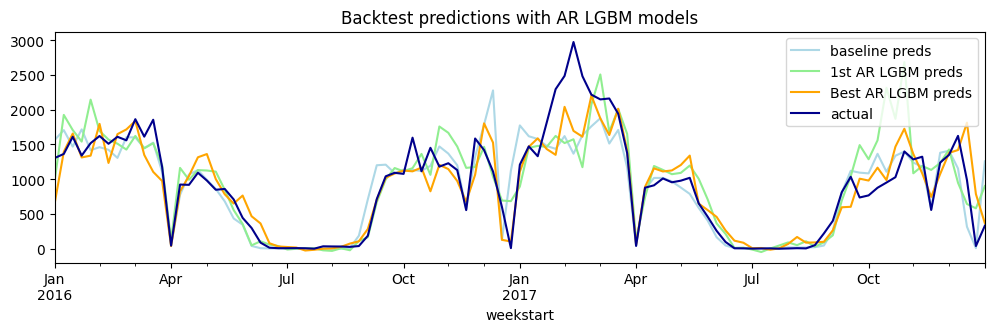

In [195]:
# Plot backtest predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3))
predictions_eq_dt.rename(columns={'pred':'baseline preds'}).plot(ax=ax,color='lightblue')
predictions_ar1.rename(columns={'pred':'1st AR LGBM preds'}).plot(ax=ax,color='lightgreen')
predictions_ar2.rename(columns={'pred':'Best AR LGBM preds'}).plot(ax=ax,color='orange')
df.loc[end_train:end_validation]['cases'].plot(ax=ax, label='actual', color='darkblue')

ax.set_title('Backtest predictions with AR LGBM models')
ax.legend()

In [196]:
print(f' Baseline MAE        :  {round(metric_eq_dt)} \n \
1st AR LGBM MAE     :  {round(metric_ar1)} \n \
Best AR LGBM MAE    :  {round(metric_ar2)}')

 Baseline MAE        :  216 
 1st AR LGBM MAE     :  257 
 Best AR LGBM MAE    :  200


In [223]:
predictions_eq_dt.to_csv('baseline lgbm preds .csv')
predictions_ar1.to_csv('first lgbm preds .csv')
predictions_ar2.to_csv('best lgbm preds .csv')

In [197]:
# Hyperparameters search
# ==============================================================================

# Create forecaster with a transformer categorical features
forecaster_ex1 = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 52,
                fit_kwargs = {'categorical_feature':'auto'}
            )

# Backtest model on test data
# ==============================================================================
metric_ex1, predictions_ex1 = backtesting_forecaster(
                        forecaster         = forecaster_ex1,
                        y                  = df.loc[:end_validation]['cases'],
                        steps              = 6,
                        metric             = 'mean_absolute_error',
                        initial_train_size = len(df[:end_train]),
                        refit              = False,
                        n_jobs             = 'auto',
                        verbose            = False,
                        show_progress      = True
                    )

print(f'Backtest error (MAE): {metric_ex1}')

# Lags grid
lags_grid = [[1],[1,52],[1,2],[1,2,52],[1,2,3],[1,2,3,52]]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators' : trial.suggest_int('n_estimators', 800, 1400, step=100),
        'max_depth'    : trial.suggest_int('max_depth', 3, 8, step=1),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'reg_alpha'    : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'   : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
    } 
    return search_space

results_search_ex1, frozen_trial_ex1 = bayesian_search_forecaster(
                                forecaster         = forecaster_ex1,
                                y                  = df.loc[:end_validation, 'cases'],
                                exog               = df.loc[:end_validation,].drop(columns=['cases']),
                                search_space       = search_space,
                                lags_grid          = lags_grid,
                                steps              = 6,
                                refit              = False,
                                metric             = 'mean_absolute_error',
                                initial_train_size = len(df_train),
                                fixed_train_size   = False,
                                n_trials           = 20,
                                random_state       = 123,
                                return_best        = True,
                                n_jobs             = 'auto',
                                verbose            = False,
                                show_progress      = True
                            )

100%|██████████| 18/18 [00:00<00:00, 122.34it/s]


Backtest error (MAE): 257.1923846903494
Number of models compared: 120,
         20 bayesian search in each lag configuration.


lags grid: 100%|██████████| 6/6 [01:20<00:00, 13.35s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2 52] 
  Parameters: {'n_estimators': 1100, 'max_depth': 6, 'learning_rate': 0.012790385018160863, 'reg_alpha': 0.2, 'reg_lambda': 0.0}
  Backtesting metric: 226.31451580738718



In [198]:
results_search_ex1.head()['params'].iloc[0]

{'n_estimators': 1100,
 'max_depth': 6,
 'learning_rate': 0.012790385018160863,
 'reg_alpha': 0.2,
 'reg_lambda': 0.0}

In [199]:
# Best exogenous variables model
# ==============================================================================

forecaster_ex2 = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123, verbose=-1,
                                        n_estimators= 1100,
                                        max_depth= 6,
                                        learning_rate= 0.012790385018160863,
                                        reg_alpha= 0.2,
                                        reg_lambda= 0
                                        ),
                lags       = [1,2,52],
                fit_kwargs = {'categorical_feature':'auto'}
            )

forecaster_ex2.fit(y=df.loc[:end_train, 'cases'],exog=df.loc[:end_train].drop(columns=['cases']))

metric_ex2, predictions_ex2 = backtesting_forecaster(
                        forecaster         = forecaster_ex2,
                        y                  = df.loc[:end_validation]['cases'],
                        exog               = df.loc[:end_validation].drop(columns=['cases']),
                        steps              = 6,
                        metric             = 'mean_absolute_error',
                        initial_train_size = len(df[:end_train]),
                        refit              = False,
                        n_jobs             = 'auto',
                        verbose            = False,
                        show_progress      = True
                    )

print(f'Backtest error (MAE): {metric_ex2}')

100%|██████████| 18/18 [00:00<00:00, 89.16it/s]

Backtest error (MAE): 226.31451580738718


In [200]:
forecaster_ex2.get_feature_importances().sort_values(by='importance', ascending=False)

,feature,importance
7,GS_flu,1051
0,lag_1,838
16,Ozone,764
1,lag_2,622
22,visits,597
2,lag_52,473
6,GS_fever,445
5,GS_cough,411
3,epiweek,390
39,TMIN_L2,281


---

In [201]:
# Underlying matrices used by the forecaster to fit the internal regressor
# ==============================================================================
X_train, y_train = forecaster_ex2.create_train_X_y(
                    y    = df_train['cases'],
                    exog = df_train.drop(columns=['cases'])
                )

In [219]:
# Recursive feature elimination with cross-validation
# ==============================================================================
# Sample 50% of the data to speed up the calculation
rng = np.random.default_rng(seed=785412)
sample = rng.choice(X_train.index, size=int(len(X_train)*0.5), replace=False)
X_train_sample = X_train.loc[sample, :]
y_train_sample = y_train.loc[sample]

regressor = LGBMRegressor(random_state=123, verbose=-1,
                                        n_estimators= 1100,
                                        max_depth= 6,
                                        learning_rate= 0.012790385018160863,
                                        reg_alpha= 0.2,
                                        reg_lambda= 0
                                        )

selector = RFECV(
    estimator              = regressor,
    step                   = 1,
    cv                     = 3,
    min_features_to_select = 15,
    n_jobs                 = -1
)
selector.fit(X_train_sample, y_train_sample)
selected_features_rfe = selector.get_feature_names_out()

print("Recursive feature elimination")
print("-----------------------------")
print(f"Total number of features available: {X_train.shape[1]}") 
print(f"Total number of records available: {X_train.shape[0]}")
print(f"Total number of records used for feature selection: {X_train_sample.shape[0]}")
print(f"Number of features selected: {len(selected_features_rfe)}")
print(f"Selected features : \n {selected_features_rfe}")

Recursive feature elimination
-----------------------------
Total number of features available: 40
Total number of records available: 521
Total number of records used for feature selection: 260
Number of features selected: 33
Selected features : 
 ['lag_1' 'lag_2' 'lag_52' 'epiweek' 'GS_cold' 'GS_cough' 'GS_fever'
 'GS_flu' 'AWND' 'PRCP' 'SNOW' 'TAVG' 'TMAX' 'TMIN' 'Overall AQI Value'
 'Ozone' 'PM10' 'PM25' 'Days Good' 'visits' 'epiweek_sin' 'epiweek_cos'
 'GS_cold_L1' 'GS_cold_L2' 'GS_fever_L1' 'GS_fever_L2' 'AWND_L1' 'TAVG_L1'
 'TAVG_L2' 'TMAX_L1' 'TMAX_L2' 'TMIN_L1' 'TMIN_L2']


In [220]:
# Create forecaster with the selected features
# ==============================================================================

selected_exog_features = [
    feature
    for feature in selected_features_rfe
    if not feature.startswith("lag_")
]

forecaster_exbest = ForecasterAutoreg(
                regressor        = LGBMRegressor(random_state=123, verbose=-1,
                                        n_estimators= 1100,
                                        max_depth= 6,
                                        learning_rate= 0.012790385018160863,
                                        reg_alpha= 0.2,
                                        reg_lambda= 0
                                        ),
                lags             = [1,2,52]
            )

forecaster_exbest.fit(y=df_train['cases'], exog=df_train[selected_exog_features])

# Backtesting model with exogenous variables on test data
# ==============================================================================
metric_exbest, predictions_exbest = backtesting_forecaster(
                            forecaster         = forecaster_exbest,
                            y                  = df[:end_validation]['cases'],
                            exog               = df[:end_validation][selected_exog_features],
                            steps              = 6,
                            metric             = 'mean_absolute_error',
                            initial_train_size = len(df[:end_train]),
                            refit              = False,
                            n_jobs             = 'auto',
                            verbose            = False,
                            show_progress      = True
                        )

print(f"Backtest error: {metric_exbest:.2f}")

100%|██████████| 18/18 [00:00<00:00, 109.04it/s]

Backtest error: 218.22


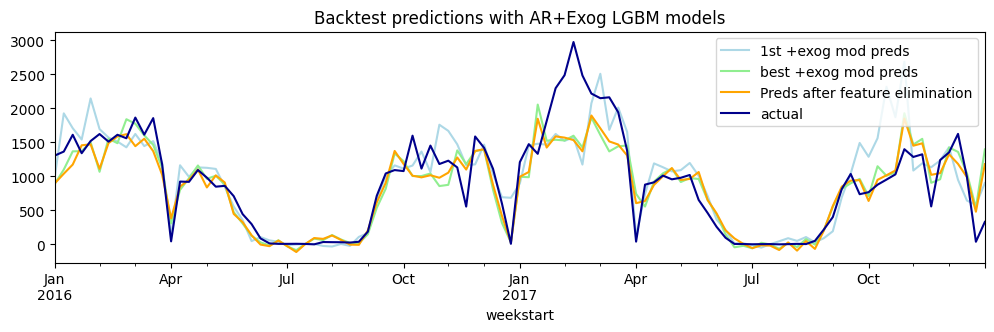

In [221]:
# Plot backtest predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3))
predictions_ex1.rename(columns={'pred':'1st +exog mod preds'}).plot(ax=ax,color='lightblue')
predictions_ex2.rename(columns={'pred':'best +exog mod preds'}).plot(ax=ax,color='lightgreen')
predictions_exbest.rename(columns={'pred':'Preds after feature elimination'}).plot(ax=ax,color='orange')
df.loc[end_train:end_validation]['cases'].plot(ax=ax, label='actual', color='darkblue')

ax.set_title('Backtest predictions with AR+Exog LGBM models')
ax.legend()

In [224]:
predictions_ex1.to_csv('first exog lgbm preds .csv')
predictions_ex2.to_csv('best exog lgbm preds .csv')
predictions_exbest.to_csv('best after feature elimination lgbm preds .csv')

In [228]:
print('Autoregression')
print(f' Baseline MAE                     :  {round(metric_eq_dt)} \n \
1st AR LGBM MAE                  :  {round(metric_ar1)} \n \
Best AR LGBM MAE                 :  {round(metric_ar2)}\n')

print('Autoregression + exog variables')
print(f' 1st +exog MAE                    :  {round(metric_ex1)} \n \
best +exog MAE                   :  {round(metric_ex2)} \n \
after feature elimination MAE    :  {round(metric_exbest)}')

Autoregression
 Baseline MAE                     :  216 
 1st AR LGBM MAE                  :  257 
 Best AR LGBM MAE                 :  200

Autoregression + exog variables
 1st +exog MAE                    :  257 
 best +exog MAE                   :  226 
 after feature elimination MAE    :  218


In [241]:

backtesting_forecaster(
                        forecaster         = forecaster_ar2,
                        y                  = df.loc[:end_validation]['cases'],
                        steps              = 2,
                        metric             = 'mean_absolute_error',
                        initial_train_size = len(df[:end_train]),
                        refit              = False,
                        n_jobs             = 'auto',
                        verbose            = False,
                        show_progress      = True
                    )

100%|██████████| 53/53 [00:00<00:00, 131.17it/s]


(195.76967927795704,
                    pred
 2016-01-03   666.045382
 2016-01-10  1393.979448
 2016-01-17  1684.285386
 2016-01-24  1540.291872
 2016-01-31  1949.517987
 ...                 ...
 2017-12-03  1487.528610
 2017-12-10  1385.656875
 2017-12-17  1814.801269
 2017-12-24   786.565470
 2017-12-31  1091.853444
 
 [105 rows x 1 columns])